In [24]:
import time

import random as python_random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from tensorflow.keras.utils import to_categorical

from mlxtend.plotting import plot_confusion_matrix


rseed = 42
np.random.seed(rseed)
python_random.seed(rseed)
tf.random.set_seed(rseed)

#### Load Data

In [2]:
#load the dataframes created in the Data.ipynb section
X_train = pd.read_csv('..\data\X_train.csv')
X_val = pd.read_csv('..\data\X_val.csv')
X_test = pd.read_csv('..\data\X_test.csv')

y_train_bin = pd.read_csv('..\data\y_train_bin.csv')
y_val_bin = pd.read_csv('..\data\y_val_bin.csv')
y_test_bin = pd.read_csv('..\data\y_test_bin.csv')

y_train_multi = pd.read_csv('..\data\y_train_multi.csv')
y_val_multi = pd.read_csv('..\data\y_val_multi.csv')
y_test_multi = pd.read_csv('..\data\y_test_multi.csv')

In [3]:
#turn string labels into float categories, categs is list of categories
y_train_multi, categs = pd.factorize(y_train_multi.connection_category)
y_val_multi, categs = pd.factorize(y_val_multi.connection_category)
y_test_multi, categs = pd.factorize(y_test_multi.connection_category)
#turn float categories into tf.keras matrix categories of dimension length(categs)
#e.g. 'normal' = [1,0,0,0,0]
y_train_multi = to_categorical(y_train_multi, num_classes = len(categs))
y_val_multi = to_categorical(y_val_multi, num_classes = len(categs))
y_test_multi = to_categorical(y_test_multi, num_classes = len(categs))

## Training

In [4]:
def binaryDNN(train_df = X_train, hidden_nodes = [10,10,10], op = 'adam', metrics = [tf.keras.metrics.AUC()]):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model
    nn_model.compile(loss='binary_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

def multiDNN(train_df = X_train, num_classes = 5, hidden_nodes = [10,10,10], op = 'adam', metrics = ['accuracy']):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(num_classes, activation = 'softmax'))
    
    #compile model
    nn_model.compile(loss='categorical_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

In [5]:
x1 = -np.arange(1,5)
epsilons = np.float_power(10,x1)

In [6]:
epsilons

array([0.1   , 0.01  , 0.001 , 0.0001])

Train binary and multiclass models for SGD, SGD, and SGD.

In [7]:
#jupyter works a bit differently from a normal IDE 
#so we have to set random seed again in this cell
tf.random.set_seed(rseed)

count = 1
epochs = 30
batch_size = 10**3
start = time.time()

#5 learning rates equally spaced between 1/10,000 and 1/100
for eps in epsilons:
    
    #create the 3 optimizer with learning rate above
    sgd_opt = tf.keras.optimizers.SGD(learning_rate = eps,
                                      momentum = 0.9,
                                      nesterov = False)

    # nag_opt = tf.keras.optimizers.SGD(learning_rate = eps, 
    #                                   momentum = 0.9, 
    #                                   nesterov = True)
    
    
    # adam_opt = tf.keras.optimizers.SGD(learning_rate = eps)

    #fit same model architecture for each optimizer
    for opt in ['sgd']:
        #assign optimizer as above
        optimizer = locals()['{}_opt'.format(opt)] 
        
        #compile model with appropriate optimizer
        bin_model_temp = binaryDNN(op = optimizer)
        #record model history fitting to binary training data with validation split
        print('-'*10 + 'Fitting binary model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin,
                                              shuffle = True, validation_data = (X_val, y_val_bin),
                                              epochs = epochs, batch_size = batch_size,
                                              verbose = 0)
        
        #assign models and their history to appropriately named variable in locals()
        locals()['{}_bin_model_{}'.format(opt,count)] = bin_model_temp
        locals()['{}_bin_history_{}'.format(opt,count)] = bin_history_temp
        
        #delete temp model and history to free up memory
        del bin_model_temp
        del bin_history_temp
    
    
    
        #same as before but for multiclass categ
        categ_model_temp = multiDNN(op = optimizer)
        print('-'*10 + 'Fitting categorical model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi,
                                                  shuffle = True, validation_data = (X_val, y_val_multi),
                                                  epochs = epochs, batch_size = batch_size,
                                                  verbose = 0)
    
        locals()['{}_categ_model_{}'.format(opt,count)] = categ_model_temp
        locals()['{}_categ_history_{}'.format(opt,count)] = categ_history_temp
         
        del categ_model_temp
        del categ_history_temp
        print()
        
    #increase count for iteration on next epsilon value
    count += 1
    
end = time.time()

----------Fitting binary model to sgd optimizer with learning rate 0.1----------
----------Fitting categorical model to sgd optimizer with learning rate 0.1----------

----------Fitting binary model to sgd optimizer with learning rate 0.01----------
----------Fitting categorical model to sgd optimizer with learning rate 0.01----------

----------Fitting binary model to sgd optimizer with learning rate 0.001----------
----------Fitting categorical model to sgd optimizer with learning rate 0.001----------

----------Fitting binary model to sgd optimizer with learning rate 0.0001----------
----------Fitting categorical model to sgd optimizer with learning rate 0.0001----------



In [8]:
print('Time taken to run all models:  {:2f} seconds'.format(end-start))

Time taken to run all models:  357.855733 seconds


### Plots and Assessing Performance

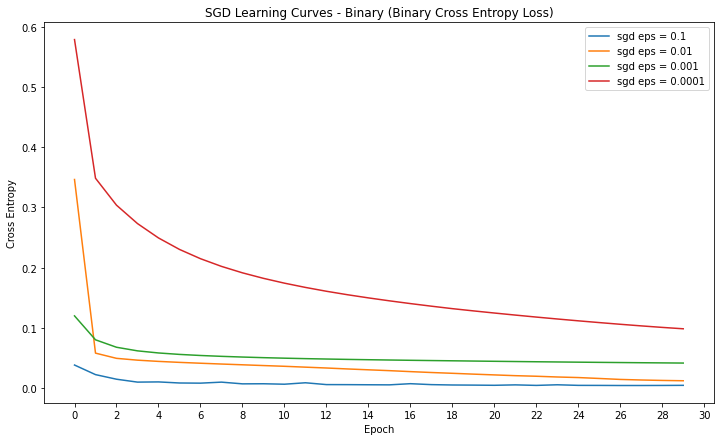

In [9]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Binary (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

count=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1

# plt.plot(adam_bin_history_5.history['val_loss'],label='adam eps = 0.0001')

plt.legend()
plt.show()

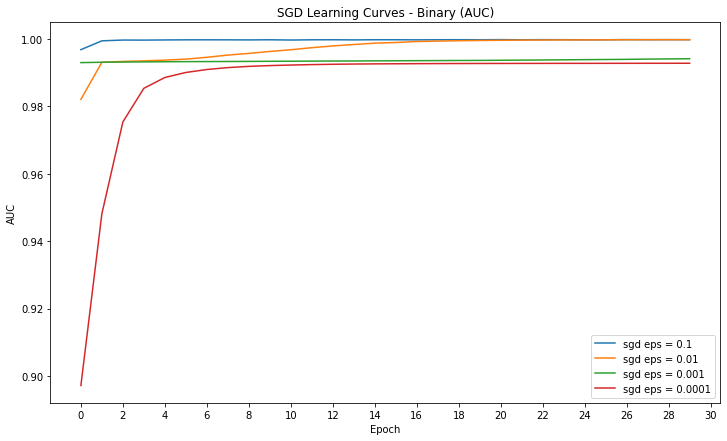

In [10]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')

count=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_auc'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_auc'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_auc'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_auc'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1# plt.plot(adam_bin_history_5.history['val_auc'],label='adam eps = 0.0001')

plt.legend()
plt.show()

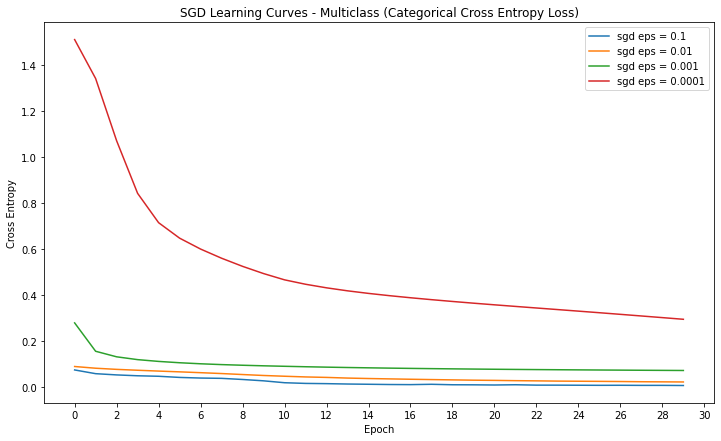

In [11]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

count=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1

plt.legend()
plt.show()

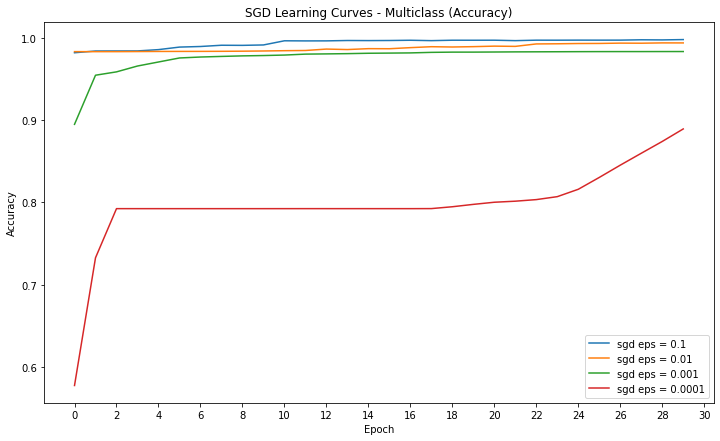

In [12]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

count=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_accuracy'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_accuracy'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_accuracy'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1
plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_accuracy'],label='{} eps = {}'.format(opt, epsilons[count-1]))
count+=1

plt.legend()
plt.show()

In [13]:
tf.random.set_seed(rseed)
sgd_pred = sgd_bin_model_1.predict(X_test)

In [14]:
sgd_pred_bin = sgd_pred
sgd_pred_bin[sgd_pred_bin>0.5]=1
sgd_pred_bin[sgd_pred_bin<0.5]=0

Text(0.5, 1.0, 'Confusion Matrix for SGD with learning rate 0.1')

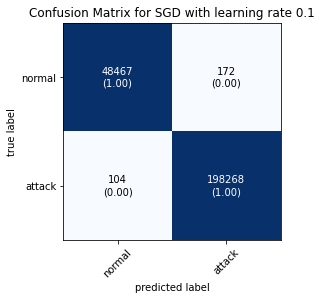

In [15]:
cmat_sgd = confusion_matrix(y_test_bin,sgd_pred)
cmat_sgd

plot_confusion_matrix(
    conf_mat = cmat_sgd,
    show_normed = True,
    class_names = ['normal','attack']
)

plt.title('Confusion Matrix for SGD with learning rate {}'.format(epsilons[0]))

In [16]:
tf.random.set_seed(rseed)

for i in range(len(epsilons)):
    
    model = locals()['sgd_categ_model_{}'.format(i+1)]
    sgd_categ_pred = model.predict(X_test)
    locals()['sgd_categ_pred_{}'.format(i+1)] = sgd_categ_pred

In [17]:
categs

Index(['dos', 'normal', 'probe', 'r2l', 'u2r'], dtype='object')

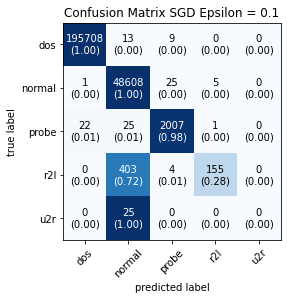

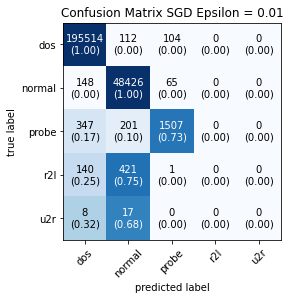

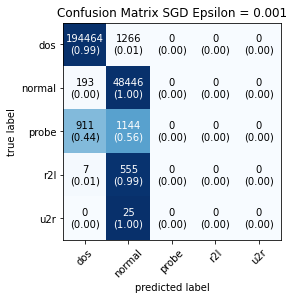

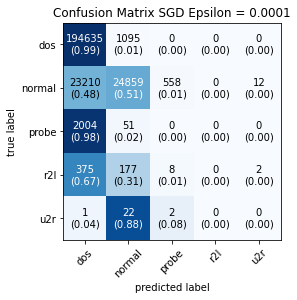

In [18]:
for i in range(len(epsilons)):
    sgd_categ_pred = locals()['sgd_categ_pred_{}'.format(i+1)]
    
    cmat_categ_sgd = confusion_matrix(tf.argmax(y_test_multi,axis=1), tf.argmax(sgd_categ_pred,axis=1))
    
    locals()['cmat_categ_sgd_{}'.format(i)] = cmat_categ_sgd
   
    
    
    plot_confusion_matrix(
        conf_mat = cmat_categ_sgd,
        show_normed = True,
        class_names = categs
    )
    plt.title('Confusion Matrix {} Epsilon = {}'.format(opt.upper(),epsilons[i]))
    
del sgd_categ_pred

In [19]:
def binaryDNN(train_df = X_train, hidden_nodes = [10,10,10], op = 'adam', metrics = [tf.keras.metrics.AUC()]):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model
    nn_model.compile(loss='binary_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

def multiDNN(train_df = X_train, num_classes = 5, hidden_nodes = [10,10,10], op = 'adam', metrics = ['accuracy']):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(num_classes, activation = 'softmax'))
    
    #compile model
    nn_model.compile(loss='categorical_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

Train binary and multiclass models for NAG, SGD, and SGD.

In [20]:
count = 1

start = time.time()

#5 learning rates equally spaced between 1/10,000 and 1/100
for eps in np.linspace(1/10000,1/100,5):
    
    eps = round(eps,5)
    #create the 3 optimizer with learning rate above
    sgd_opt = tf.keras.optimizers.SGD(learning_rate = eps,
                                      momentum = 0.9,
                                      nesterov = False)

#     nag_opt = tf.keras.optimizers.SGD(learning_rate = eps, 
#                                       momentum = 0.9, 
#                                       nesterov = True)
    
    
    # adam_opt = tf.keras.optimizers.SGD(learning_rate = eps)

    #fit same model architecture for each optimizer
    for opt in ['sgd']:
        #assign optimizer as above
        optimizer = locals()['{}_opt'.format(opt)] 
        
        #compile model with appropriate optimizer
        bin_model_temp = binaryDNN(op = optimizer)
        #record model history fitting to binary training data with validation split
        print('-'*10 + 'Fitting binary model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin,
                                              shuffle = True, validation_data = (X_val, y_val_bin),
                                              epochs = 30, batch_size = 10000)
        
        #assign models and their history to appropriately named variable in locals()
        locals()['{}_bin_model_{}'.format(opt,count)] = bin_model_temp
        locals()['{}_bin_history_{}'.format(opt,count)] = bin_history_temp
        
        #delete temp model and history to free up memory
        del bin_model_temp
        del bin_history_temp
    
        #same as before but for multiclass categ
        categ_model_temp = multiDNN(op = optimizer)
        print('-'*10 + 'Fitting categorical model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi,
                                                  shuffle = True, validation_data = (X_val, y_val_multi),
                                                  epochs = 30, batch_size = 10000)
    
        locals()['{}_categ_model_{}'.format(opt,count)] = categ_model_temp
        locals()['{}_categ_history_{}'.format(opt,count)] = categ_history_temp
         
        del categ_model_temp
        del categ_history_temp
        print()
        
    #increase count for iteration on next epsilon value
    count += 1
    
end = time.time()

----------Fitting binary model to sgd optimizer with learning rate 0.0001----------
Epoch 1/30
5/5 [==============================] - 2s 247ms/step - loss: 0.5823 - auc_1: 0.9756 - val_loss: 0.5816 - val_auc_1: 0.9752
Epoch 2/30
5/5 [==============================] - 0s 101ms/step - loss: 0.5804 - auc_1: 0.9761 - val_loss: 0.5789 - val_auc_1: 0.9751
Epoch 3/30
5/5 [==============================] - 0s 101ms/step - loss: 0.5773 - auc_1: 0.9760 - val_loss: 0.5752 - val_auc_1: 0.9756
Epoch 4/30
5/5 [==============================] - 0s 97ms/step - loss: 0.5734 - auc_1: 0.9765 - val_loss: 0.5710 - val_auc_1: 0.9759
Epoch 5/30
5/5 [==============================] - 0s 98ms/step - loss: 0.5690 - auc_1: 0.9767 - val_loss: 0.5665 - val_auc_1: 0.9762
Epoch 6/30
5/5 [==============================] - 0s 99ms/step - loss: 0.5644 - auc_1: 0.9769 - val_loss: 0.5618 - val_auc_1: 0.9758
Epoch 7/30
5/5 [==============================] - 0s 100ms/step - loss: 0.5596 - auc_1: 0.9775 - val_loss: 0.5569 -

In [21]:
print('Time taken to run all models:  {:2f} seconds'.format(end-start))

Time taken to run all models:  113.050027 seconds


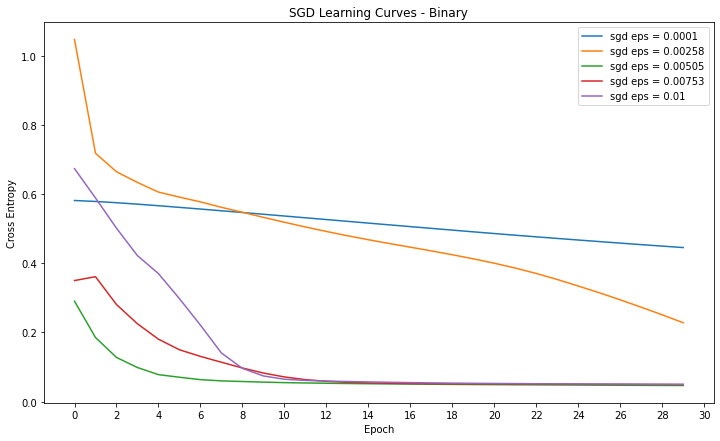

In [22]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(sgd_bin_history_1.history['val_loss'],label='sgd eps = 0.0001')
plt.plot(sgd_bin_history_2.history['val_loss'],label='sgd eps = 0.00258')
plt.plot(sgd_bin_history_3.history['val_loss'],label='sgd eps = 0.00505')
plt.plot(sgd_bin_history_4.history['val_loss'],label='sgd eps = 0.00753')
plt.plot(sgd_bin_history_5.history['val_loss'],label='sgd eps = 0.01')

plt.legend()
plt.show()

KeyError: 'val_auc'

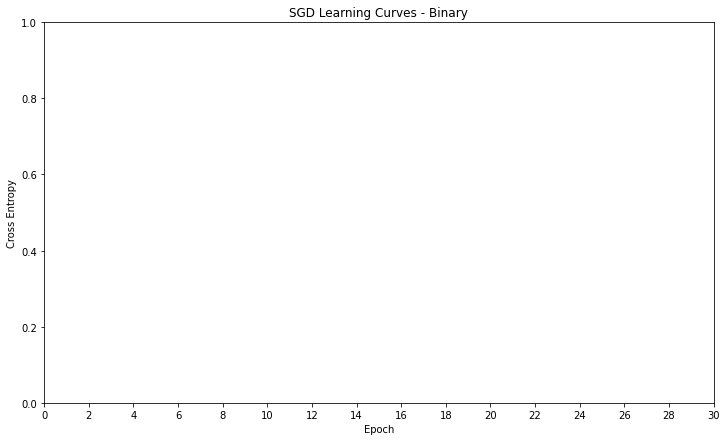

In [23]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(sgd_bin_history_1.history['val_auc'],label='sgd eps = 0.0001')
plt.plot(sgd_bin_history_2.history['val_auc'],label='sgd eps = 0.00258')
plt.plot(sgd_bin_history_3.history['val_auc'],label='sgd eps = 0.00505')
plt.plot(sgd_bin_history_4.history['val_auc'],label='sgd eps = 0.00753')
plt.plot(sgd_bin_history_5.history['val_auc'],label='sgd eps = 0.01')

plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(sgd_categ_history_1.history['val_loss'],label='sgd eps = 0.0001')
plt.plot(sgd_categ_history_2.history['val_loss'],label='sgd eps = 0.00258')
plt.plot(sgd_categ_history_3.history['val_loss'],label='sgd eps = 0.00505')
plt.plot(sgd_categ_history_4.history['val_loss'],label='sgd eps = 0.00753')
plt.plot(sgd_categ_history_5.history['val_loss'],label='sgd eps = 0.01')

plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(sgd_categ_history_1.history['val_accuracy'],label='sgd eps = 0.0001')
plt.plot(sgd_categ_history_2.history['val_accuracy'],label='sgd eps = 0.00258')
plt.plot(sgd_categ_history_3.history['val_accuracy'],label='sgd eps = 0.00505')
plt.plot(sgd_categ_history_4.history['val_accuracy'],label='sgd eps = 0.00753')
plt.plot(sgd_categ_history_5.history['val_accuracy'],label='sgd eps = 0.01')

plt.legend()
plt.show()

In [ ]:
sgd_pred = sgd_bin_model_3.predict(X_test)

In [ ]:
sgd_pred_bin = sgd_pred
sgd_pred_bin[sgd_pred_bin>0.5]=1
sgd_pred_bin[sgd_pred_bin<0.5]=0

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
import matplotlib

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cmat_sgd = confusion_matrix(y_test_bin,sgd_pred)
cmat_sgd
plot_confusion_matrix(
    conf_mat = cmat_sgd,
    show_normed = True
)

In [ ]:
sgd_categ_pred = sgd_categ_model_4.predict(X_test)

In [ ]:
sgd_categ_pred

In [ ]:
cmat_sgd = confusion_matrix(tf.argmax(y_test_multi,axis=1), tf.argmax(sgd_categ_pred,axis=1))

plot_confusion_matrix(
    conf_mat = cmat_sgd,
    show_normed = True
)